In [1]:
from functions import map_scatter, glasbey, get_colours_from
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel
from google.cloud import storage
from scipy import stats
from scipy.spatial import Delaunay
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import QuantileTransformer
from matplotlib.patches import Polygon
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
# import nfinder
import copy
import os

In [2]:
# read in data
data_path = "gs://mayo-nguyen-transplant/nduarte-csv/data.csv"
df = pd.read_csv(data_path)

In [3]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'Slide',
       'UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1',
       'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1', 'PC1_hcorr', 'PC2_hcorr',
       'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr',
       'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'UMAP1_hcorr', 'UMAP2_hcorr',
       'Leiden', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Phenotype',
       'Timepoint'],
      dtype='object')

In [4]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1_hcorr', 'UMAP2_hcorr', 'PC1_hcorr', 'PC2_hcorr', 'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr', 'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'Leiden', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint']
markers = ['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

In [5]:
print(len(df[df['Phenotype'] == 'Other']))
print(len(df[df['Phenotype'] != 'Other']))

2625254
2123365


Quantile Transform for plotting heatmap - so that red in one marker means the same thing as red in another marker.

In [6]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df[markers] = qt.fit_transform(df[markers])

### Hierarchical Clustering
Based on Figure S1C of [this](https://pubmed.ncbi.nlm.nih.gov/37059105/) paper.

Level 1 clustermap on a random subset

In [7]:
# get the proportion of each group in level 1
for p in df['Level 1'].unique():
    prop = len(df[df['Level 1'] == p]) / len(df.index)
    print(p, prop)
    

Other 0.5528457852693593
Immune 0.4467149291193924
Epithelial 0.0004392856112482387


In [8]:
# reduce size by getting mean within lymph nodes within level
df_mean = df[markers + ['Parent', 'Level 1']].groupby(['Parent']).mean(numeric_only=True).reset_index()

In [9]:
df_mean.head()

,Parent,DAPI,CD44,HLA-DR,CD4,IFNG,Ki67,CD107a,CD45,CD20,CD40,CD8,Pan-Cytokeratin,CD68,HLA-A,CD79a,CD45RO,CD21,CD11c,HLA-E,IDO1,CD14,CD56,VISTA,FOXP3,Granzyme B,PCNA,T-bet/TBX21,PD-L1,TOX,PD-1,CD38,ICOS,CD39,LAG3,TCF-1,CD3e
0,Slide 10 C1,0.291725,-0.142130,-0.430299,-0.549045,-1.496045,-0.817269,0.091314,-0.456568,-0.046605,-0.256461,-2.406130,-0.728329,0.231205,-0.386901,-0.331670,-0.046388,-0.947105,-0.421370,-1.080000,-0.461503,-1.028572,0.285825,-0.774280,0.034144,-3.563019,0.124964,-0.194242,-0.333972,-0.917635,-0.475313,-0.657059,-0.399201,-0.434412,0.225941,0.126321,-0.334169
1,Slide 10 C1-1,-0.011105,-0.528192,-0.518456,-1.015172,-1.186648,-0.492853,-0.201397,-1.051366,-0.596109,-0.415323,-2.787949,-0.922423,-0.142553,0.052442,-0.660734,-0.763203,-1.637883,-1.061367,-1.448860,-1.421706,-0.676819,0.138905,-1.039409,-0.089720,-3.642357,-0.781648,0.864929,-0.718437,-1.388672,-1.385022,-0.581292,-0.860856,-0.661774,0.013009,-0.339529,-0.825560
2,Slide 10 D1,0.266539,-0.621925,-0.294454,-0.500075,-1.655121,-0.715519,-0.079671,-0.739046,-0.402642,0.033832,-2.187037,-0.861315,0.807567,0.257527,-0.547469,-0.224169,-1.568001,-0.502583,-0.680252,-0.669066,-0.947855,0.509867,-1.386605,0.479779,-3.938475,-0.045191,0.134182,-0.521421,-1.914751,-0.104964,-0.908698,-0.333649,-1.228658,0.521804,-0.148196,-0.469636
3,Slide 11 A1,0.203101,-0.009640,0.141576,0.282005,0.054851,0.350699,0.037902,0.055326,0.115395,0.025962,0.176094,0.468861,-0.150670,-0.185602,0.171507,0.674536,0.301718,0.427595,0.563691,-0.316698,0.147443,-0.382889,0.262360,-0.079359,-0.453346,-0.288873,0.112440,0.356929,0.412020,0.229669,0.252312,0.322143,0.340124,-0.634565,0.070791,0.266248
4,Slide 11 A1-1,0.025269,0.134199,0.284987,0.149960,-0.127646,0.205462,0.420003,0.259252,0.124076,0.319555,-0.481309,0.170169,0.568170,0.259198,0.288266,0.109284,0.203298,-0.026065,0.281448,0.057336,0.164803,0.411515,0.175922,0.168508,-0.847606,0.309057,0.481864,0.083828,0.273520,0.046729,0.512194,0.081174,0.187838,0.032944,-0.036088,0.036242


In [10]:
df_mean.columns

Index(['Parent', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a',
       'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A',
       'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56',
       'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX',
       'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e'],
      dtype='object')

In [11]:
# reduce size by getting sample
lvl1_markers = ['CD45', 'Pan-Cytokeratin', 'CD3e', 'CD20', 'CD11c']
df_ss = df.sample(frac=0.1, random_state=57)

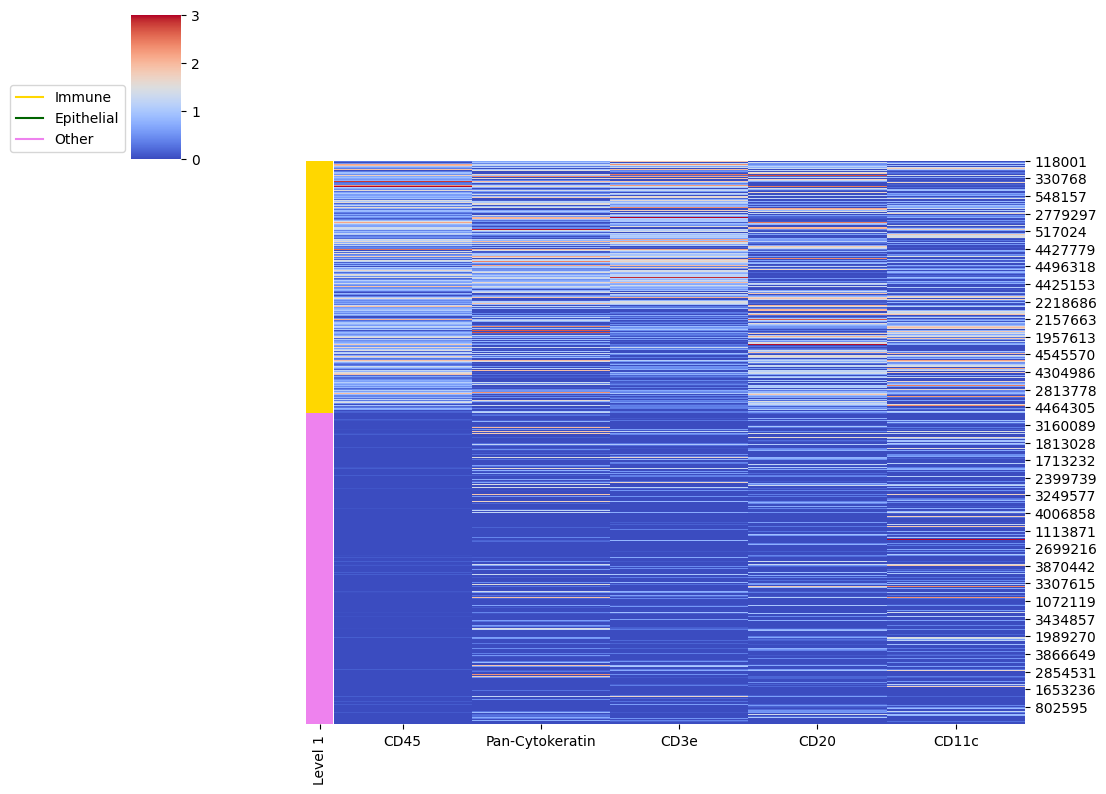

In [12]:
level1_colours = {
    'Immune': 'gold',
    'Epithelial': 'darkgreen',
    'Other': 'violet'
}

df_sorted = df_ss.sort_values(by=['Level 1', 'Level 2'])
row_colours = df_sorted['Level 1'].map(level1_colours) # map each row to a colour based on level
df_biomarkers = df_sorted[lvl1_markers] 

# plot
cg = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cg.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
for label in level1_colours:
    plt.plot([], [], color=level1_colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()

In [13]:
# reduce size by getting sample
filtered = df_ss[df_ss['Level 1'] == 'Immune'] # get the immune subset

In [35]:
rest_markers = ['CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD20', 'CD40', 'CD8', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

levels = ['Level 2', 'Level 3', 'Level 4']

level2_colours = {
    'Lymphoid': 'gold',
    'Myeloid': 'darkorange',
    'Other': 'white'
}

level3_colours = {phen: colour for phen, colour in zip(df['Level 3'].unique(), glasbey(len(df['Level 3'].unique())))}
level3_colours['Other'] = 'white'

cmap_l4 = mpl.cm.get_cmap('tab20b', len(df['Level 4'].unique()))
level4_colours = {phen: cmap_l4(i) for i, phen in enumerate(df['Level 4'].unique())}
level4_colours['Other'] = 'white'

df_sorted = df_ss.sort_values(by=levels)
row_lv2_colours = df_sorted['Level 2'].map(level2_colours) # map each row to a colour based on level
row_lv3_colours = df_sorted['Level 3'].map(level3_colours)
row_lv4_colours = df_sorted['Level 4'].map(level4_colours)
df_biomarkers = df_sorted[rest_markers] 
row_colours = pd.concat([row_lv4_colours, row_lv3_colours, row_lv2_colours], axis=1)
row_colours.head()

/tmp/ipykernel_2937/3570792342.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_l4 = mpl.cm.get_cmap('tab20b', len(df['Level 4'].unique()))


,Level 4,Level 3,Level 2
4365131,"(0.8705882352941177, 0.6196078431372549, 0.839...","(0.423529, 0.0, 0.309804)",gold
1904563,"(0.8705882352941177, 0.6196078431372549, 0.839...","(0.423529, 0.0, 0.309804)",gold
1877454,"(0.8705882352941177, 0.6196078431372549, 0.839...","(0.423529, 0.0, 0.309804)",gold
2109117,"(0.8705882352941177, 0.6196078431372549, 0.839...","(0.423529, 0.0, 0.309804)",gold
2071994,"(0.8705882352941177, 0.6196078431372549, 0.839...","(0.423529, 0.0, 0.309804)",gold


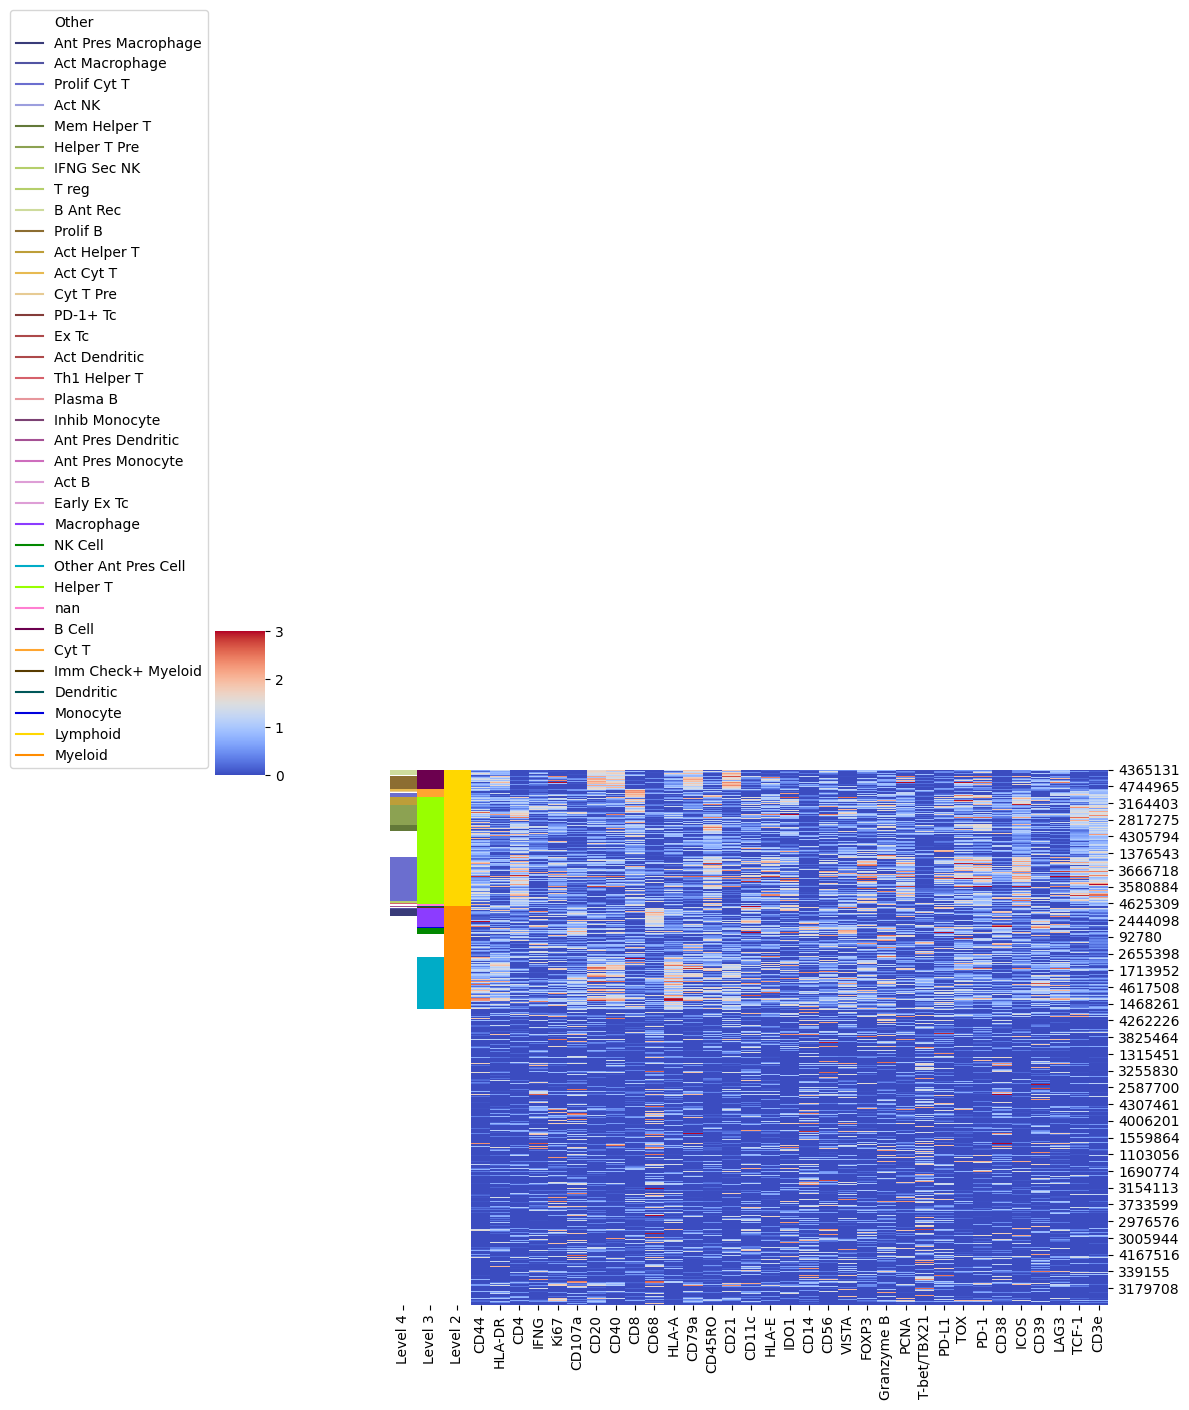

In [36]:
# plot
cm = sns.clustermap(df_biomarkers, row_colors=row_colours, cmap='coolwarm', figsize=(10, 8), vmin=0, vmax=3, row_cluster=False, col_cluster=False)
# cm.ax_heatmap.set_yticks([]) # suppress y-ticks

# legend - figure out separate legends 
colours = level4_colours | level3_colours | level2_colours
for label in colours:
    plt.plot([], [], color=colours[label], label=label)
plt.legend(loc='lower right', bbox_to_anchor=(0, 0))

plt.show()